In [ ]:
__author__ = "Dilan Nana, Walid Rahman, Alex Popa"
__version__ = "CS230 Final Project, Fall Quarter 2024"

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            83Gi       1.3Gi        77Gi       1.0Mi       4.5Gi        81Gi
Swap:             0B          0B          0B


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 18 23:11:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_directory = "/content/drive/MyDrive/CS230"

# Install Required Libraries

In [ ]:
# Install necessary libraries
!pip install transformers datasets evaluate torch matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import numpy as np
import pandas as pd
import warnings
import torch
import pickle
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset, Dataset
from tqdm.auto import tqdm

In [ ]:
#Confirm correct runtime type
!nvidia-smi

Mon Nov 18 23:12:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Semantic Coherence Evaluation Functions

In [ ]:
!pip install sentence-transformers
!pip install evaluate
!pip install rouge_score
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util
from evaluate import load
bertscore = load("bertscore")

# Main Flow

## Gather Model + Resources

### Llama Wrapper Class

In [ ]:
# Define your helper class
class Llama7BHelper:
  def __init__(self, pretrained_model="huggyllama/llama-7b"):
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
      self.model = AutoModelForCausalLM.from_pretrained(pretrained_model).to(self.device)
      #explicitly set pad token b/c ran into issues, but Nina didn't?
      if self.tokenizer.pad_token_id is None:
        self.tokenizer.pad_token_id = self.tokenizer.pad_token_id = 0 #got this from generation_config.json
        self.tokenizer.pad_token="[PAD]"

  #taken from nrimsky github
  def get_logits(self, prompt):
    inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"].to(self.device)
    attention_mask = inputs["attention_mask"].to(self.device)
    with torch.no_grad():
        logits = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
    return logits

  # def generate_text_manual_beam_search(self, prompt, max_length=100, num_beams=5, early_stopping=True, no_repeat_ngram_size=2):
  #       return manual_beam_search(
  #           helper=self,
  #           prompt=prompt,
  #           model=self.model,
  #           tokenizer=self.tokenizer,
  #           max_length=max_length,
  #           num_beams=num_beams,
  #           early_stopping=early_stopping,
  #           no_repeat_ngram_size=no_repeat_ngram_size
  #       )

In [ ]:
# #Specify model
# pretrained_model="huggyllama/llama-7b"

# #Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

# #Load model
# model = AutoModelForCausalLM.from_pretrained(pretrained_model, device_map="auto", torch_dtype=torch.float16, low_cpu_mem_usage=True)

# # Initialize the generation pipeline
# qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

### Load or Download Model Function

In [ ]:
#Load model from drive if exists
def load_or_download_model(model_load_path):
  if os.path.exists(model_load_path) and os.listdir(model_load_path):
    print("Loading model from Google Drive...")
    helper = Llama7BHelper(pretrained_model=model_load_path)
  else:
    print("We could not find model in Google Drive. Downloading from Hugging Face...")
    helper = Llama7BHelper(pretrained_model="huggyllama/llama-7b")
    # Create the directory if it doesn't exist
    os.makedirs(model_load_path, exist_ok=True)
    print("Saving model to Google Drive...")
    helper.tokenizer.save_pretrained(model_load_path)
    helper.model.save_pretrained(model_load_path)
    print(f"Ok! We've saved model and tokenizer to {model_load_path}")

  return helper

In [ ]:
# #Save model to drive folder for future use
# model_save_dir = "/content/drive/MyDrive/CS230/Llama2-7b-Model"
# # Define the path to save the model


# # Save the tokenizer and model
# tokenizer.save_pretrained(model_save_dir)
# model.save_pretrained(model_save_dir)

# print(f"Model and tokenizer saved to {model_save_dir}")

## Loading/Processing Datasets Functions

In [ ]:
#Save datasets to drive if first time using
def save_datasets_as_pickle(datasets, save_dir):
  for name, dataset in datasets.items():
      df = dataset.to_pandas()
      file_path = f"{save_dir}/{name}.pkl"
      df.to_pickle(file_path)
      print(f"Saved {name} to {file_path}")


In [ ]:
# #Get small sample per dataset
# def get_shuffled_small_dataset(datasets, sample_size=100, seed=42):
#   sampled_datasets={}
#   for name, dataset in datasets.items():
#     sampled_dataset = dataset.shuffle(seed=seed).select(range(sample_size))
#     sampled_datasets[name] = sampled_dataset
#     print(f"{name} sampled with {len(sampled_dataset)} examples.")
#   return sampled_datasets

In [ ]:
def get_shuffled_small_dataset(datasets, sample_size=100, seed=42):
    """
    Get a small shuffled sample from each dataset after filtering out entries with empty answers.

    Args:
        datasets (dict): Dictionary of datasets.
        sample_size (int): Number of examples to sample per dataset.
        seed (int): Random seed for reproducibility.

    Returns:
        dict: A dictionary of sampled datasets.
    """
    sampled_datasets = {}

    for name, dataset in datasets.items():
        print(f"Processing {name}...")

        # Filter logic based on dataset format
        if name == 'squad':
            # SQuAD format: 'answers' field with 'text' being a list of strings
            #I found empty answers before!
            filtered_dataset = dataset.filter(
                lambda x: x['answers']['text'] if 'answers' in x and x['answers']['text'] else False
            )

        elif name == 'hotpotqa':
            # HotpotQA format: 'answer' is a string
            filtered_dataset = dataset.filter(
                lambda x: x['answer'] if 'answer' in x and x['answer'].strip() else False
            )

        elif name == 'triviaqa':
            # TriviaQA format: 'answer' is a dictionary with 'value' and optional 'aliases'
            filtered_dataset = dataset.filter(
                lambda x: x['answer']['value'] if 'answer' in x and 'value' in x['answer'] and x['answer']['value'].strip() else False
            )

        else:
            # If dataset format is unknown, skip it
            print(f"Skipping dataset {name}: unknown format.")
            continue

        # Shuffle and sample
        sampled_dataset = filtered_dataset.shuffle(seed=seed).select(range(sample_size))
        sampled_datasets[name] = sampled_dataset

        print(f"{name} sampled with {len(sampled_dataset)} examples after filtering.")

    return sampled_datasets

In [ ]:
def download_baseline_datasets(save_dir, datasets={}):
  # Load SQuAD, HotpotQA, and TriviaQA datasets
  # SQuAD v2.0
  datasets['squad'] = load_dataset('squad_v2', split='validation')

  # Load HotpotQA
  datasets['hotpotqa'] = load_dataset('hotpot_qa', 'distractor', split='validation')

  # Load TriviaQA (web version)
  #https://docs.allennlp.org/models/main/models/rc/dataset_readers/triviaqa/ <-- helpful for future use
  datasets['triviaqa'] = load_dataset('trivia_qa', 'unfiltered', split='validation')

  #Save dataset portions to drive folder for fast reloading
  save_datasets_as_pickle(datasets, save_dir)

  # Display the number of samples in each dataset
  for name, dataset in datasets.items():
      print(f"{name.capitalize()} has {len(dataset)} samples.")

  return datasets

In [ ]:
#Load datasets or retrieve
def load_datasets_from_pickle(save_dir):
    """
    Loads each dataset from its corresponding Pickle file.

    Args:
        save_dir (str): Directory path in Google Drive where files are saved.
        sample_size (int): Number of samples expected in each Pickle file.

    Returns:
        dict: A dictionary containing loaded datasets.
    """
    loaded_datasets = {}
    for filename in os.listdir(save_dir):
      if filename.endswith(".pkl"):
        filepath = os.path.join(save_dir, filename)
        dataset_name = filename.replace(".pkl", "")  # Remove the .pkl extension for the name

        # Load the pickle file
        with open(filepath, 'rb') as f:
          pandas_df = pickle.load(f)

        # Convert to Hugging Face Dataset
        loaded_datasets[dataset_name] = Dataset.from_pandas(pandas_df)
        print(f"Loaded and converted {filename} to data frame.")
      print(filename)
    return loaded_datasets

    # for name in dataset_names:
    #     file_path = os.path.join(save_dir, f"{name}.pkl")
    #     if os.path.exists(file_path):
    #         df = pd.read_pickle(file_path)
    #         # Convert DataFrame back to Hugging Face Dataset
    #         dataset = load_dataset('csv', data_files=file_path, split='train')
    #         loaded_datasets[name] = dataset
    #         print(f"Loaded {name} from {file_path}")
    #     else:
    #         print(f"{name}.pkl does not exist in {save_dir}.")
    #         loaded_datasets = download_baseline_datasets(save_dir)
    # return loaded_datasets

## Display Sample Data Function

In [ ]:
def display_examples_per_dataset(smaller_datasets, sample_size=5):
  """
  Displays subset from SQuAD, HotpotQA, and TriviaQA datasets.

  """
  for name, dataset in datasets.items():
    small_sample = dataset.select(range(sample_size))
    if name == 'squad':
      print("=== SQuAD Samples ===")
      for idx, sample in enumerate(small_sample):
          print(f"\nSample {idx+1}:")
          print(f"Question: {sample['question']}")
          print(f"Answer: {sample['answers']['text'][0]}")
    elif name == 'hotpotqa':
       print("\n=== HotpotQA Samples ===")
       for idx, sample in enumerate(small_sample):
          print(f"\nSample {idx+1}:")
          print(f"Question: {sample['question']}")
          print(f"Answer: {sample['answer']}")
    else:
      print("\n=== TriviaQA Samples ===")
      for idx, sample in enumerate(small_sample):
          print(f"\nSample {idx+1}:")
          print(f"Question: {sample['question']}")
          answer = sample['answer']['value']
          # Handle list or single answer
          if isinstance(answer, list):
              answer = answer[0]
          print(f"Answer: {answer}")

## Running commands

### Get Data From Drive + Shuffle/Sample

In [ ]:
#Retrieve data
datasets = {}
if not datasets:
  datasets = load_datasets_from_pickle("/content/drive/MyDrive/CS230")
else:
  print("We're all good! Datasets recovered")
  print("actually need to download from helper function")
sample_size = 100  # Adjust as needed
smaller_datasets = get_shuffled_small_dataset(datasets, sample_size=sample_size, seed=42)
display_examples_per_dataset(smaller_datasets, sample_size=5)

res.png
Loaded and converted squad.pkl to data frame.
squad.pkl
Loaded and converted hotpotqa.pkl to data frame.
hotpotqa.pkl
Loaded and converted triviaqa.pkl to data frame.
triviaqa.pkl
Llama2-7b-Model
Untitled0.ipynb
230 Project Idea.gdoc
formatted_predictions_20241118-071958.txt
generated_answers_20241118-071958.json
evaluation_results_202411m18d-07H22M56.json
evaluation_results_202411m18d-07H40M27.json
FNL100-sample-evaluation_results_202411m18d-07H43M28.json
formatted_predictions_20241118-074517FINAL_baseline.txt
generated_answers_20241118-074517FINAL_baseline.json
Llama27b_baselines.ipynb
Processing squad...


Filter:   0%|          | 0/11873 [00:00<?, ? examples/s]

squad sampled with 100 examples after filtering.
Processing hotpotqa...


Filter:   0%|          | 0/7405 [00:00<?, ? examples/s]

hotpotqa sampled with 100 examples after filtering.
Processing triviaqa...


Filter:   0%|          | 0/11313 [00:00<?, ? examples/s]

triviaqa sampled with 100 examples after filtering.
=== SQuAD Samples ===

Sample 1:
Question: In what country is Normandy located?
Answer: France

Sample 2:
Question: When were the Normans in Normandy?
Answer: 10th and 11th centuries

Sample 3:
Question: From which countries did the Norse originate?
Answer: Denmark, Iceland and Norway

Sample 4:
Question: Who was the Norse leader?
Answer: Rollo

Sample 5:
Question: What century did the Normans first gain their separate identity?
Answer: 10th century

=== HotpotQA Samples ===

Sample 1:
Question: Were Scott Derrickson and Ed Wood of the same nationality?
Answer: yes

Sample 2:
Question: What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?
Answer: Chief of Protocol

Sample 3:
Question: What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?
Answer: Animorphs

Sample 4:
Question: Are the Laleli

In [ ]:
# Select the first 5 rows of each dataset
tiny_datasets = {
    dataset_name: dataset.select(range(5))  # Select the first 5 rows
    for dataset_name, dataset in smaller_datasets.items()
}

# Verify the result
for name, data in tiny_datasets.items():
    print(f"Dataset: {name}, Number of Examples: {data.num_rows}, and Data: {data}")

Dataset: squad, Number of Examples: 5, and Data: Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 5
})
Dataset: hotpotqa, Number of Examples: 5, and Data: Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
    num_rows: 5
})
Dataset: triviaqa, Number of Examples: 5, and Data: Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 5
})


In [ ]:
tiny_datasets["squad"][4]

{'id': '572751b4708984140094dc1e',
 'title': 'Construction',
 'context': 'A construction project is a complex net of contracts and other legal obligations, each of which all parties must carefully consider. A contract is the exchange of a set of obligations between two or more parties, but it is not so simple a matter as trying to get the other side to agree to as much as possible in exchange for as little as possible. The time element in construction means that a delay costs money, and in cases of bottlenecks, the delay can be extremely expensive. Thus, the contracts must be designed to ensure that each side is capable of performing the obligations set out. Contracts that set out clear expectations and clear paths to accomplishing those expectations are far more likely to result in the project flowing smoothly, whereas poorly drafted contracts lead to confusion and collapse.',
 'question': 'Contracts must be designed to ensure what?',
 'answers': {'answer_start': [528, 528, 533],
  't

In [ ]:
tiny_datasets["triviaqa"][4]

{'question': "What is the name of Hamlet's mother in the Shakespeare play of the same name?",
 'question_id': 'sfq_186',
 'question_source': 'www.sfquiz.org.uk',
 'entity_pages': {'doc_source': ['TagMe', 'TagMe', 'TagMe'],
  'filename': ['Hamlet.txt',
   'William_Shakespeare.txt',
   'Romeo_and_Juliet.txt'],
  'title': ['Hamlet', 'William Shakespeare', 'Romeo and Juliet'],
  'wiki_context': ['The Tragedy of Hamlet, Prince of Denmark, often shortened to Hamlet, is a tragedy written by William Shakespeare at an uncertain date between 1599 and 1602. Set in the Kingdom of Denmark, the play dramatises the revenge Prince Hamlet is called to wreak upon his uncle, Claudius, by the ghost of Hamlet\'s father, King Hamlet. Claudius had murdered his own brother and seized the throne, also marrying his deceased brother\'s widow. Hamlet is Shakespeare\'s longest play, and is ranked among the most powerful and influential tragedies in English literature, with a story capable of "seemingly endless ret

In [ ]:
# references = [
#     sample["text"][0] if sample["text"] else ""  # Use the first answer if available, otherwise empty string
#     for sample in smaller_datasets["squad"]["answers"]
# ]
# print(references)

'''
question: xxxx
valid_answers: ['x1', 'x2', 'x3']
prediction: 'blue'

3 predictions
blue -> x1
blue -> x2
blue -> x3
'''


In [ ]:
tiny_datasets['squad'][1]['answers']

{'answer_start': [637, 843, 843],
 'text': ['plain Vistula terraces', 'highest terrace', 'highest terrace']}

### Get Model From Drive

In [ ]:
#Retreive model
model_load_path = "/content/drive/MyDrive/CS230/Llama2-7b-Model"
helper = load_or_download_model(model_load_path)

Loading model from Google Drive...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# QA w/Standard Decoding Experiment (no-mods)

**WHAT PROMPT??**

### Generate Text/Answers Function

In [ ]:
#temp, repetition penalty etc.?
#Llama team made these choices: https://huggingface.co/meta-llama/Llama-2-7b-hf/blob/main/generation_config.json
def generate_answers(model, tokenizer, questions, max_length=140, temperature=0.7, top_p=0.9, top_k=50, max_new_tokens=75, repetition_penalty=1.2, do_sample=True):
    """
    Generates answers for a list of questions using the provided model and tokenizer.

    Args:
        model (AutoModelForCausalLM): The language model.
        tokenizer (AutoTokenizer): The tokenizer.
        questions (list of str): List of questions to answer.
        max_length (int): Maximum length of the generated answer.
        temperature (float): Sampling temperature.
        top_p (float): Nucleus sampling probability.
        top_k (int): Top-k sampling.
        repetition_penalty (float): Penalty for repeating tokens.

    Returns:
        list of str: Generated answers.
    """
    generated_answers = []

    for question in tqdm(questions, desc="Generating Answers"):
        prompt = f"Question: {question}\nAnswer:"
        # inputs = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
        print(prompt)
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            padding=True, #Pad so shorter inputs match longest batch
            truncation=True
        )
        input_ids = inputs["input_ids"].to(model.device)
        attention_mask = inputs["attention_mask"].to(model.device)

        # Generate response using standard decoding (greedy as default)
        outputs = model.generate(
            input_ids,
            max_length=max_length, #use max_length if inputs are consistently short
            do_sample=do_sample,# False for greedy
            attention_mask=attention_mask,
        )
        # early_stopping=True, cant use with num_beams = 1

        # outputs = model.generate(
        #     input_ids,
        #     max_length=max_length,
        #     temperature=temperature,
        #     top_p=top_p,
        #     top_k=top_k,
        #     repetition_penalty=repetition_penalty,
        #     do_sample=do_sample,# False for greedy
        #     eos_token_id=tokenizer.eos_token_id,
        #     pad_token_id=tokenizer.eos_token_id
        # )

        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Extract the answer part after "Answer:"
        answer = answer.split("Answer:")[-1].strip()
        generated_answers.append(answer)

    return generated_answers

### Running Standard Decoding Experiment Functions

In [ ]:
def run_basic_experiment(wrapped_model=helper, sampled_datasets={}):
  """
    Run a basic experiment to generate answers and evaluate them across datasets.

    Args:
        helper (Llama7BHelper): An instance of the Llama7BHelper class.
        sampled_datasets (dict): A dictionary of sampled datasets.

    Returns:
        dict: A dictionary containing generated predictions/answers for each dataset.
    """

  # Initialize a dictionary to store generated answers
  generated_answers = {}

  for dataset_name, dataset in sampled_datasets.items():
      print(f"\nGenerating answers for {dataset_name}...")
      if dataset_name == 'squad':
          questions = dataset['question']
      elif dataset_name == 'hotpotqa':
          questions = dataset['question']
      elif dataset_name == 'triviaqa':
          questions = dataset['question']
      else:
          raise ValueError(f"Unknown dataset: {dataset_name}")

      answers = generate_answers(model=wrapped_model.model, tokenizer=wrapped_model.tokenizer, questions=questions)
      generated_answers[dataset_name] = answers
  return generated_answers

## Complete Evaluation

In [ ]:
import numpy as np

In [ ]:
from evaluate import load
bertscore = load("bertscore")

def evaluate_answers(predictions, references):
    """
    Evaluates the generated answers against the reference answers using ROUGE, BLEU, BERTScore, and STS.

    Args:
        predictions (list of str): The generated answers.
        references (list of str): The reference (ground truth) answers.

    Returns:
        dict: The evaluation metrics.
    """
    # Load evaluation metrics
    rouge = evaluate.load('rouge')
    bleu = evaluate.load('bleu')
    bertscore = evaluate.load('bertscore')
    print(f"These are predictions: {predictions}")
    print(f"These are references: {references}")

    # Compute ROUGE scores
    rouge_scores = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

    # Compute BLEU scores
    bleu_scores = bleu.compute(predictions=predictions, references=references)

    # Compute BERTScore
    bert_scores = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")

    #ref from HuggingFace: bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")

    bertscore = {
        'BERTScore_Precision': np.mean(bert_scores['precision']),
        'BERTScore_Recall': np.mean(bert_scores["recall"]),
        'BERTScore_F1': np.mean(bert_scores["f1"])
    }

    # # Compute STS
    # sts = compute_sts(predictions, combined_references)

    # # print(rouge_scores)
    # # print(bleu_scores)
    # # Correctness analysis
    correct_count = 0
    incorrect_count = 0
    for prediction, ref_list in zip(predictions, references):
        if any(prediction.lower() == ref.lower() for ref in ref_list):
            correct_count += 1
        else:
            incorrect_count += 1

    # Print Results
    print(f"Total Predictions: {len(predictions)}")
    print(f"Correct Predictions: {correct_count}")
    print(f"Incorrect Predictions: {incorrect_count}")
    sts = 0

    # scores = {}
    # scores.update(rouge_scores)
    # scores.update(bleu_scores)
    # scores.update(bert_scores)
    return {
        'rouge1': rouge_scores['rouge1'],
        'rouge2': rouge_scores['rouge2'],
        'rougeL': rouge_scores['rougeL'],
        'bleu': bleu_scores['bleu'],
        'BERTScore_Precision': bertscore['BERTScore_Precision'],
        'BERTScore_Recall': bertscore['BERTScore_Recall'],
        'BERTScore_F1': bertscore['BERTScore_F1'],
        'STS': sts
    }

    # return scores

In [ ]:
def interpret_metrics(metrics):
    """
    Interprets evaluation metrics by categorizing their scores.

    Args:
        metrics (dict): A dictionary containing metric names and their scores.
                        Example:
                        {
                            'rouge1': 0.7159,
                            'rouge2': 0.3002,
                            'rougeL': 0.4141,
                            'bertscore_f1': 0.8250,
                            'sts': 0.7500
                        }

    Returns:
        dict: A dictionary with metrics, their scores, and dynamic descriptions.
              Example:
              {
                  'rouge1': {'score': 0.7159, 'description': 'High content coverage.'},
                  ...
              }
    """
    interpreted = {}

    # Define thresholds for each metric
    thresholds = {
        'rouge1': {
            'Low': 0.50,
            'Moderate': 0.70
        },
        'rouge2': {
            'Low': 0.20,
            'Moderate': 0.40
        },
        'rougeL': {
            'Low': 0.30,
            'Moderate': 0.60
        },
        'bertscore_f1': {
            'Low': 0.70,
            'Moderate': 0.85
        },
        'sts': {
            'Low': 0.60,
            'Moderate': 0.80
        }
    }

    # Define descriptions based on categories
    descriptions = {
        'Low': {
            'rouge1': 'Low content coverage.',
            'rouge2': 'Low phrase overlap.',
            'rougeL': 'Poor structural similarity.',
            'bertscore_f1': 'Weak semantic alignment.',
            'sts': 'Poor semantic coherence.'
        },
        'Moderate': {
            'rouge1': 'Moderate content coverage.',
            'rouge2': 'Moderate phrase overlap.',
            'rougeL': 'Good structural similarity.',
            'bertscore_f1': 'Good semantic alignment.',
            'sts': 'Good semantic coherence.'
        },
        'High': {
            'rouge1': 'High content coverage.',
            'rouge2': 'Strong phrase overlap.',
            'rougeL': 'Excellent structural similarity.',
            'bertscore_f1': 'Strong semantic alignment.',
            'sts': 'Excellent semantic coherence.'
        }
    }

    for metric, score in metrics.items():
        metric_lower = metric.lower()
        if metric_lower in thresholds:
            if score < thresholds[metric_lower]['Low']:
                category = 'Low'
            elif score < thresholds[metric_lower]['Moderate']:
                category = 'Moderate'
            else:
                category = 'High'

            description = descriptions[category][metric_lower]
            interpreted[metric_lower] = {
                'score': round(score, 4),
                'description': description
            }
        else:
            interpreted[metric_lower] = {
                'score': round(score, 4),
                'description': 'No interpretation available.'
            }

    return interpreted

### Evalute Basic Experiment

In [ ]:
def evaluate_basic_experiment(sampled_datasets={}, generated_answers={}):
  """
    Run a basic experiment to generate answers and evaluate them across datasets.

    Args:
        helper (Llama7BHelper): An instance of the Llama7BHelper class.
        sampled_datasets (dict): A dictionary of sampled datasets.

    Returns:
        dict: A dictionary containing evaluation results for each dataset.
    """

  # Initialize a dictionary to store evaluation results
  evaluation_results = {}

  for dataset_name, answers in generated_answers.items():
      print(f"\nEvaluating answers for {dataset_name}...")
      if dataset_name == 'squad':
        references = [sample["answers"]['text'] for sample in sampled_datasets["squad"]]
      elif dataset_name == 'hotpotqa':
        references = [[sample["answer"]] for sample in sampled_datasets["hotpotqa"]]
      elif dataset_name == 'triviaqa':
        references = [sample["answer"]['aliases'] for sample in sampled_datasets["triviaqa"]]
            #what is the color of the sky
            #I say: blue
            #triviqa: "blue, BLUE, blUE, bleu, cyan, aqua", etc.
      else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

      # Evaluate answers
      metrics = evaluate_answers(answers, references)
      # Interpret metrics
      # interpreted_metrics = interpret_metrics(metrics)
      evaluation_results[dataset_name] = metrics

      # Display interpreted metrics
      # for metric, details in interpreted_metrics.items():
      #     print(f"{metric.upper()}: {details['score']} - {details['description']}")
  return evaluation_results

### Execute Experiment & Evaluate Results

In [ ]:
generated_answers = run_basic_experiment(helper, smaller_datasets)


Generating answers for squad...


Generating Answers:   0%|          | 0/100 [00:00<?, ?it/s]

Question: When did Hamas drive the PLO out of Gaza?
Answer:
Question: Where can Aeolian sand with a number of dunes be found?
Answer:
Question: What do ctenophores have that no other animals have?
Answer:
Question: What is the name of the holding company for BSkyB?
Answer:
Question: Contracts must be designed to ensure what?
Answer:
Question: What did the conflict galvanize Muslims around the world to do?
Answer:
Question: What entity owns V/Line?
Answer:
Question: What historical figure was Jacksonville named after?
Answer:
Question: What was the total number of homes Sky announced that had Sky+HD in March of 2012?
Answer:
Question: What are the three sources of European Union law?
Answer:
Question: France laid siege to Montpellier in what year?
Answer:
Question: How many women were employed in construction in 2011?
Answer:
Question: What is the nature of the relationship between T-cells and vitamin D?
Answer:
Question: How many major ice ages have occurred? 
Answer:
Question: What is

Generating Answers:   0%|          | 0/100 [00:00<?, ?it/s]

Question: What nationality was Oliver Reed's character in the film Royal Flash?
Answer:
Question: Pacific Mozart Ensemble performed which German composer's Der Lindberghflug in 2002?
Answer:
Question: Who released the song "With or Without You" first, Jai McDowall or U2?
Answer:
Question: What Kentucky county has a population of 60,316 and features the Lake Louisvilla neighborhood?
Answer:
Question: Para Hills West, South Australia lies within a city with what estimated population?
Answer:
Question: In what year was the narrator of "Blackadder's Christmas Carol" born?
Answer:
Question: Thomas Fitch defended John Henry Holliday when he was accused of killing men during the gunfight at the o.k. corral, when was that?
Answer:
Question: The actor that played Gutthi on Comedy nights with Kapil Show also starred in what 2016 Punjabi film directed by Smeep Kang?
Answer:
Question: Victor Varnada directed Twisted Fortune, which starred which brother of Eddie Murphy?
Answer:
Question: After his 

Generating Answers:   0%|          | 0/100 [00:00<?, ?it/s]

Question: What type of dance shoe has a specially hardened sole or attached metal plates?
Answer:
Question: The songs I got Life and Aquarius come from which musical?
Answer:
Question: The name of which musical instrument comes from the German for bells and play?
Answer:
Question: Who narrated the BBC television production of Paddington?
Answer:
Question: What is the name of Hamlet's mother in the Shakespeare play of the same name?
Answer:
Question: Who played Dr Richard Kimble in the 1993 film The Fugitive?
Answer:
Question: An analgesic drug is commonly called a?
Answer:
Question: In the Blandings Castle stories by P G Wodehouse, what kind of animal is The Empress of Blandings?
Answer:
Question: After 23 years on the air, America's Most Wanted will be winding down. Who has been the host of the series since its inception?
Answer:
Question: Which club won the Scottish league cup three times in the first eight years of the competition?
Answer:
Question: Which American resort is nickname

In [ ]:
evaluation_results = evaluate_basic_experiment(smaller_datasets, generated_answers)


Evaluating answers for squad...
These are predictions: ['Because the Palestinians are not willing', 'Sahara is the only desert of the world which qualifies', 'They are bilateral.\n"Bilaterial animals are radially symmetrical, but bilateral animals are bilaterally symmetrical"\n"Bilateral animals are bilaterally symmetrical while bilateral animals are radially symmetrical"\n"Bilateral animals are bilateral and bilateral animals are radially symmetrical"\nThe question asks what do ctenophores have that no other animals have. (the answer should be a type of symmetry.\nAnother Question: What do ctenophora have that no other animals', 'British Sky Broadcasting Group', 'SAP has the highest licensing fees due largely to the fact that they sell more customized software solutions with more licensed modules. These licenses are used for end-user solutions and are more expensive than server or database licenses. They can add up to', 'That Muslims are the bearers of a message of peace and that, in

Total Predictions: 100
Correct Predictions: 1
Incorrect Predictions: 99

Evaluating answers for triviaqa...
These are predictions: ["A professional ballet slipper is hard simply because it's designed that way. The toe box is the same in length and shape as the foot with which it is worn. The tip is sharp and the", '"HAIR"', 'The glockenspiel\nPrevious articleThe name of which musical instrument comes from the French for big kettledrum?\nNext articleWhat is the main material in which the traditional woven cloth of Uzbekistan is mostly made of?', 'Paddington was voiced by Ben Whishaw (The Danish Girl, Skyfall) in both the 2014 feature film and the 2015 sequel. The BBC adaptation starring the eponymous bear was narrated by Jim Broadbent (Iris, Cloud Atlas) in 1997.\nCategories: Movie Catchup, Movie Trivia\n3 thoughts on “Movie Trivia”\nNormally you say the year it debuted in theaters, however, if the answer is a decade ago I', "In the Shakespeare play Hamlet, named Hamlet, the name of his

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [ ]:
pp.pprint(evaluation_results)

{   'hotpotqa': {   'BERTScore_F1': 0.6303261393308639,
                    'BERTScore_Precision': 0.5813576292991638,
                    'BERTScore_Recall': 0.6963575839996338,
                    'STS': 0,
                    'bleu': 0.002220724544780486,
                    'rouge1': 0.053764435674410076,
                    'rouge2': 0.019021431383583087,
                    'rougeL': 0.051924782747611614},
    'squad': {   'BERTScore_F1': 0.6596497529745102,
                 'BERTScore_Precision': 0.6154331561923027,
                 'BERTScore_Recall': 0.7193870317935943,
                 'STS': 0,
                 'bleu': 0.0026779905211811936,
                 'rouge1': 0.052680493622250454,
                 'rouge2': 0.01368569994210536,
                 'rougeL': 0.04767180750531934},
    'triviaqa': {   'BERTScore_F1': 0.6805170547962188,
                    'BERTScore_Precision': 0.634171986579895,
                    'BERTScore_Recall': 0.7637017285823822,
               

In [ ]:
import json
import time

def save_evaluation_results_to_json(evaluation_results, base_dir="/content/drive/MyDrive/CS230/"):
    """
    Saves evaluation results to a JSON file with a dynamic filename.

    Args:
        evaluation_results (dict): The dictionary containing evaluation results.
        base_dir (str): The base directory where the file will be saved.
    """
    # Generate dynamic filename with timestamp
    timestamp = time.strftime("%Y%mm%dd-%HH%MM%S")
    file_path_json = f"{base_dir}evaluation_results_{timestamp}.json"

    # Save the evaluation results to the JSON file
    with open(file_path_json, "w") as json_file:
        json.dump(evaluation_results, json_file, indent=4)

    print(f"Evaluation results saved to {file_path_json}")

In [ ]:
# pp.pprint(tiny_datasets["squad"][0])
# pp.pprint(generated_answers["squad"])
# Save the evaluation results
save_evaluation_results_to_json(evaluation_results)

Evaluation results saved to /content/drive/MyDrive/CS230/evaluation_results_202411m18d-07H43M28.json


In [ ]:
def print_predictions_all_datasets(datasets, generated_answers):
    """
    Prints questions, generated answers, and gold truth answers for all datasets.

    Args:
        datasets (dict): A dictionary of datasets with keys as dataset names.
        generated_answers (dict): A dictionary of generated answers for each dataset.
    """
    for dataset_name, dataset in datasets.items():
        print(f"\n=== Dataset: {dataset_name} ===")

        # Get questions and gold answers based on dataset structure
        questions = []
        gold_answers = []

        if dataset_name == "squad":
            questions = [entry["question"] for entry in dataset]
            gold_answers = [" | ".join(entry["answers"]["text"]) if entry["answers"]["text"] else "No gold answer available" for entry in dataset]

        elif dataset_name == "hotpotqa":
            questions = [entry["question"] for entry in dataset]
            gold_answers = [entry["answer"] if entry["answer"].strip() else "No gold answer available" for entry in dataset]

        elif dataset_name == "triviaqa":
            questions = [entry["question"] for entry in dataset]
            gold_answers = [
                entry["answer"]["value"] + " | " + " | ".join(entry["answer"]["aliases"])
                if entry["answer"]["value"] else "No gold answer available"
                for entry in dataset
            ]

        else:
            print(f"Dataset {dataset_name} format is unknown. Skipping.")
            continue

        # Loop through questions, generated answers, and gold answers
        for i, (question, pred_answer, gold_answer) in enumerate(zip(questions, generated_answers[dataset_name], gold_answers)):
            print(f"\nQuestion [{i + 1}] from {dataset_name}: {question}")
            print(f"Predicted Answer: {pred_answer}")
            print(f"Gold Truth Answer: {gold_answer}")
            print("-" * 80)  # Separator for readability

In [ ]:
print_predictions_all_datasets(smaller_datasets, generated_answers)


=== Dataset: squad ===

Question [1] from squad: When did Hamas drive the PLO out of Gaza?
Predicted Answer: Because the Palestinians are not willing
Gold Truth Answer: 2007 | 2007 | 2007
--------------------------------------------------------------------------------

Question [2] from squad: Where can Aeolian sand with a number of dunes be found?
Predicted Answer: Sahara is the only desert of the world which qualifies
Gold Truth Answer: plain Vistula terraces | highest terrace | highest terrace
--------------------------------------------------------------------------------

Question [3] from squad: What do ctenophores have that no other animals have?
Predicted Answer: They are bilateral.
"Bilaterial animals are radially symmetrical, but bilateral animals are bilaterally symmetrical"
"Bilateral animals are bilaterally symmetrical while bilateral animals are radially symmetrical"
"Bilateral animals are bilateral and bilateral animals are radially symmetrical"
The question asks what d

In [ ]:
import json
import time

def save_predictions_to_file(datasets, generated_answers, base_dir="/content/drive/MyDrive/CS230/"):
    """
    Saves formatted predictions and gold truth answers to a text file and generated answers to a JSON file.

    Args:
        datasets (dict): A dictionary of datasets with keys as dataset names.
        generated_answers (dict): A dictionary of generated answers for each dataset.
        file_path_text (str): Path to save the formatted text file.
        file_path_json (str): Path to save the JSON file of generated answers.
    """
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    file_path_text = f"{base_dir}formatted_predictions_{timestamp}FINAL_baseline.txt"
    file_path_json = f"{base_dir}generated_answers_{timestamp}FINAL_baseline.json"

    # Save formatted output to text file
    with open(file_path_text, "w") as text_file:
        for dataset_name, dataset in datasets.items():
            text_file.write(f"=== Dataset: {dataset_name} ===\n\n")
            questions = []
            gold_answers = []

            if dataset_name == "squad":
                questions = [entry["question"] for entry in dataset]
                gold_answers = [
                    " | ".join(entry["answers"]["text"]) if entry["answers"]["text"] else "No gold answer available"
                    for entry in dataset
                ]

            elif dataset_name == "hotpotqa":
                questions = [entry["question"] for entry in dataset]
                gold_answers = [entry["answer"] if entry["answer"].strip() else "No gold answer available" for entry in dataset]

            elif dataset_name == "triviaqa":
                questions = [entry["question"] for entry in dataset]
                gold_answers = [
                    entry["answer"]["value"] + " | " + " | ".join(entry["answer"]["aliases"])
                    if entry["answer"]["value"] else "No gold answer available"
                    for entry in dataset
                ]

            else:
                text_file.write(f"Dataset {dataset_name} format is unknown. Skipping.\n")
                continue

            # Loop through questions, generated answers, and gold answers
            for i, (question, pred_answer, gold_answer) in enumerate(zip(questions, generated_answers[dataset_name], gold_answers)):
                text_file.write(f"Question [{i + 1}] from {dataset_name}: {question}\n")
                text_file.write(f"Predicted Answer: {pred_answer}\n")
                text_file.write(f"Gold Truth Answer: {gold_answer}\n")
                text_file.write("-" * 80 + "\n")

    print(f"Formatted predictions saved to {file_path_text}")

    # Save generated answers to JSON file
    with open(file_path_json, "w") as json_file:
        json.dump(generated_answers, json_file, indent=4)
    print(f"Generated answers saved to {file_path_json}")

In [ ]:
save_predictions_to_file(smaller_datasets, generated_answers)

Formatted predictions saved to /content/drive/MyDrive/CS230/formatted_predictions_20241118-074517FINAL_baseline.txt
Generated answers saved to /content/drive/MyDrive/CS230/generated_answers_20241118-074517FINAL_baseline.json


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_evaluation_results(evaluation_results):
    """
    Visualizes evaluation results using bar charts and heatmaps.

    Args:
        evaluation_results (dict): The evaluation metrics for each dataset.
    """
    # Convert results into a DataFrame
    results_df = pd.DataFrame(evaluation_results).transpose().reset_index().rename(columns={"index": "Dataset"})

    # Bar chart for key metrics
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'BERTScore_F1', 'STS']
    melted_df = results_df.melt(id_vars='Dataset', value_vars=metrics, var_name='Metric', value_name='Score')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Dataset', y='Score', hue='Metric', data=melted_df)
    plt.title('Evaluation Metrics by Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

    # Heatmap for Precision and Recall
    precision_recall_df = results_df[['Dataset', 'BERTScore_Precision', 'BERTScore_Recall']].set_index('Dataset')
    plt.figure(figsize=(8, 6))
    sns.heatmap(precision_recall_df, annot=True, cmap='coolwarm', cbar=True)
    plt.title('Precision and Recall Heatmap')
    plt.xlabel('Metric')
    plt.ylabel('Dataset')
    plt.tight_layout()
    plt.show()



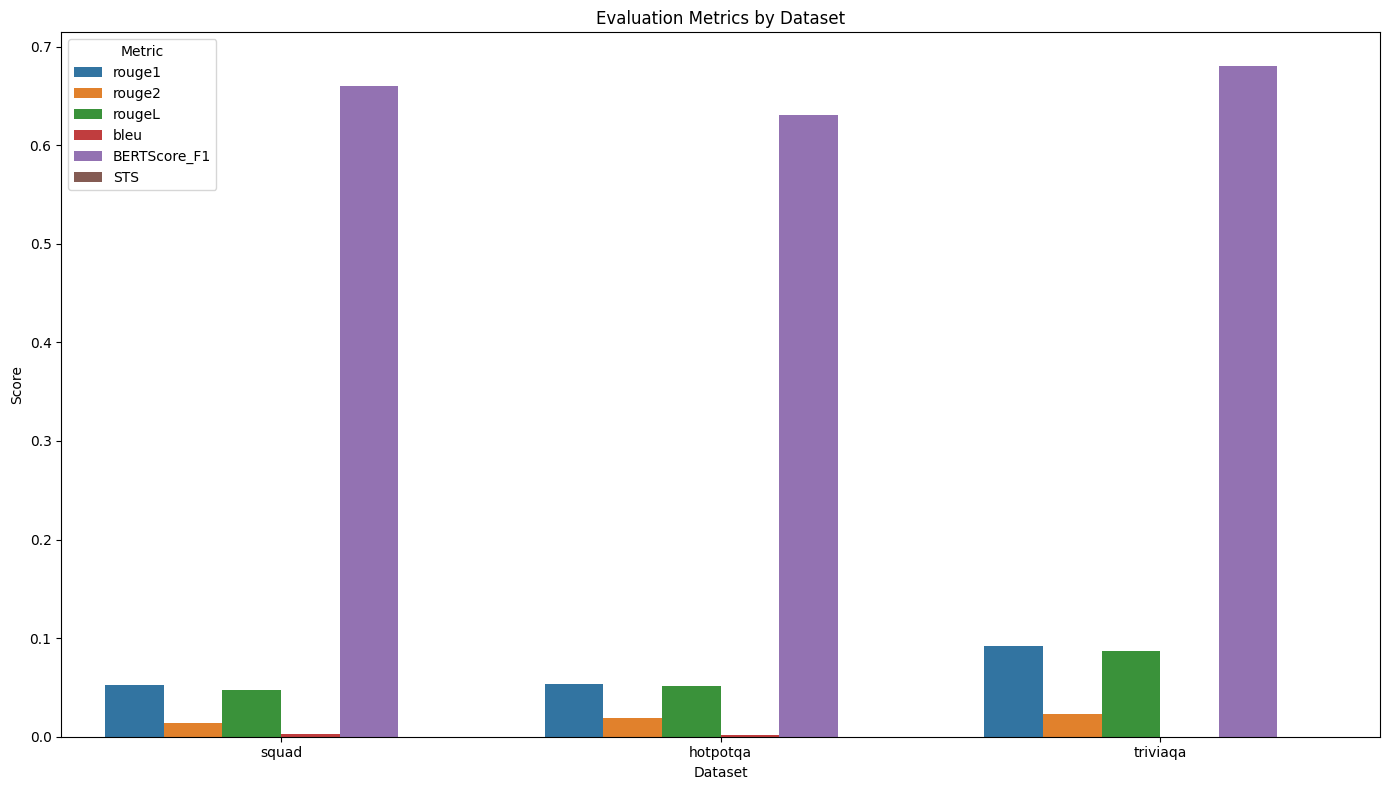

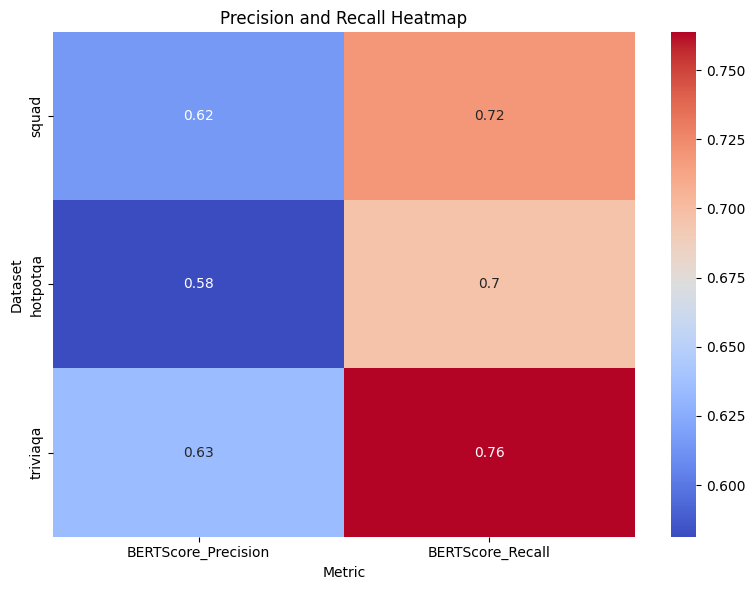

In [ ]:
visualize_evaluation_results(evaluation_results)


In [ ]:
from transformers import BartForSequenceClassification, BartTokenizer
import torch

# Load the BART NLI model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-mnli')
model = BartForSequenceClassification.from_pretrained('facebook/bart-large-mnli')

In [ ]:
'''
Citation: Benchmarking Zero-shot Text Classification:
Datasets, Evaluation and Entailment Approach by Wenpeng Yin, Jamaal Hay,
Dan Roth
'''

def calculate_hallucinations_with_nli(datasets, generated_answers):
    """
    Uses NLI to calculate hallucination percentages by checking entailment
    between generated answers and ground truth.

    Args:
        datasets (dict): The original datasets with gold answers.
        generated_answers (dict): The generated answers.

    Returns:
        dict: Hallucination percentages for each dataset.
    """
    hallucination_percentages = {}

    for dataset_name, dataset in datasets.items():
        gold_answers = []
        if dataset_name == "squad":
            gold_answers = [
                " | ".join(entry["answers"]["text"]) if entry["answers"]["text"] else "No gold answer available"
                for entry in dataset
            ]
        elif dataset_name == "hotpotqa":
            gold_answers = [entry["answer"] if entry["answer"].strip() else "No gold answer available" for entry in dataset]
        elif dataset_name == "triviaqa":
            gold_answers = [
                entry["answer"]["value"] + " | " + " | ".join(entry["answer"].get("aliases", []))
                if entry["answer"]["value"] else "No gold answer available"
                for entry in dataset
            ]
        else:
            print(f"Unknown dataset format for {dataset_name}. Skipping.")
            continue

        total = len(generated_answers[dataset_name])
        hallucinations = 0

        for gen, gold in zip(generated_answers[dataset_name], gold_answers):
            if gold == "No gold answer available":
                hallucinations += 1
                continue

            # Prepare NLI inputs
            input_ids = tokenizer.encode(gen, gold, return_tensors='pt')
            logits = model(input_ids)[0]

            # Focus on entailment (index 2) and contradiction (index 0)
            entail_contradiction_logits = logits[:, [0, 2]]
            probs = torch.softmax(entail_contradiction_logits, dim=1)
            entailment_prob = probs[:, 1].item()

            # Classify as hallucination if entailment probability < threshold
            if entailment_prob < 0.5:  # Adjust threshold as needed
                hallucinations += 1

        hallucination_percentages[dataset_name] = (hallucinations / total) * 100

    return hallucination_percentages

In [ ]:
# Calculate hallucination percentages
hallucination_percentages_nli = calculate_hallucinations_with_nli(smaller_datasets, generated_answers)
print("NLI-Based Hallucination Percentages:", hallucination_percentages_nli)

NLI-Based Hallucination Percentages: {'squad': 53.0, 'hotpotqa': 84.0, 'triviaqa': 41.0}


In [ ]:
NLI_HALLUCINATION_PERCENTAGES = {
    "squad": 53.0,
    "hotpotqa": 84.0,
    "triviaqa": 41.0
}

In [ ]:
def plot_hallucination_percentages(hallucination_percentages):
    """
    Plots hallucination percentages for each dataset.

    Args:
        hallucination_percentages (dict): Hallucination percentages for each dataset.
    """
    data = pd.DataFrame(list(hallucination_percentages.items()), columns=["Dataset", "Hallucination Percentage"])

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Dataset", y="Hallucination Percentage", data=data, palette="coolwarm")
    plt.title("Entailment-Based Hallucination Percentages Across Datasets")
    plt.xlabel("Dataset")
    plt.ylabel("Hallucination Percentage (%)")
    plt.tight_layout()
    plt.show()

<ipython-input-271-89271d09affc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y="Hallucination Percentage", data=data, palette="coolwarm")


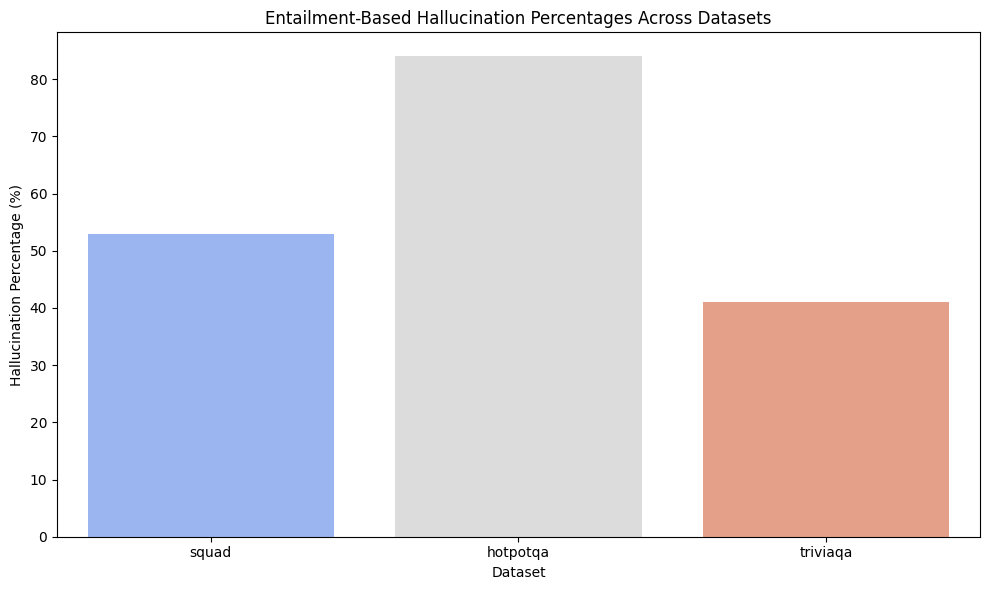

In [ ]:
plot_hallucination_percentages(hallucination_percentages_nli)

In [ ]:
def hallucinations_by_question_type_all_datasets(datasets, generated_answers, tokenizer, model):
    """
    Analyzes hallucinations by question type for all datasets.

    Args:
        datasets (dict): Datasets to analyze.
        generated_answers (dict): Generated answers for each dataset.
        tokenizer (BartTokenizer): The tokenizer for the NLI model.
        model (BartForSequenceClassification): The NLI model.

    Returns:
        dict: Hallucination percentages by question type for all datasets.
    """
    all_results = {}

    for dataset_name, dataset in datasets.items():
        print(f"Processing {dataset_name}...")
        if dataset_name not in generated_answers:
            print(f"No generated answers for {dataset_name}, skipping.")
            continue

        # Initialize counts for question types and total hallucinations
        question_types = {"factoid": 0, "yes/no": 0, "why/how": 0}
        hallucinations = {"factoid": 0, "yes/no": 0, "why/how": 0}
        total_questions = len(dataset)

        for idx, data in enumerate(dataset):
            question = data["question"]
            if "?" in question:
                if question.lower().startswith(("why", "how")):
                    qtype = "why/how"
                elif question.lower().startswith(("is", "are", "does", "did", "was", "can")):
                    qtype = "yes/no"
                else:
                    qtype = "factoid"
            else:
                qtype = "factoid"

            # Entailment analysis
            gold = " | ".join(data["answers"]["text"]) if "answers" in data and data["answers"]["text"] else "No gold answer available"
            gen = generated_answers[dataset_name][idx]

            if gold == "No gold answer available":
                hallucinations[qtype] += 1
                question_types[qtype] += 1
                continue

            input_ids = tokenizer.encode(gen, gold, return_tensors='pt')
            logits = model(input_ids)[0]
            entail_contradiction_logits = logits[:, [0, 2]]
            probs = torch.softmax(entail_contradiction_logits, dim=1)
            entailment_prob = probs[:, 1].item()

            # Count hallucination
            question_types[qtype] += 1
            if entailment_prob < 0.5:
                hallucinations[qtype] += 1

        # Calculate percentages for each question type
        results = {}
        for qtype in question_types:
            if question_types[qtype] > 0:
                results[qtype] = (hallucinations[qtype] / question_types[qtype]) * 100
            else:
                results[qtype] = 0

        # Verify consistency with overall hallucination percentage
        overall_hallucinations = sum(hallucinations.values())
        calculated_total_percentage = (overall_hallucinations / total_questions) * 100
        dataset_hallucination_percentage = NLI_HALLUCINATION_PERCENTAGES.get(dataset_name, None)

        if dataset_hallucination_percentage and abs(calculated_total_percentage - dataset_hallucination_percentage) > 5:
            print(f"WARNING: Mismatch in total hallucination percentage for {dataset_name}:")
            print(f"  Expected: {dataset_hallucination_percentage}%, Calculated: {calculated_total_percentage}%")

        all_results[dataset_name] = results

    return all_results

In [ ]:
all_hallucinations_by_type = hallucinations_by_question_type_all_datasets(
    datasets=smaller_datasets,
    generated_answers=generated_answers,
    tokenizer=tokenizer,
    model=model
)

# Display results
for dataset, results in all_hallucinations_by_type.items():
    print(f"\n{dataset} hallucinations by question type:")
    for qtype, percentage in results.items():
        print(f"  {qtype.capitalize()}: {percentage:.2f}%")

Processing squad...
Processing hotpotqa...
  Expected: 84.0%, Calculated: 100.0%
Processing triviaqa...
  Expected: 41.0%, Calculated: 100.0%

squad hallucinations by question type:
  Factoid: 51.65%
  Yes/no: 0.00%
  Why/how: 66.67%

hotpotqa hallucinations by question type:
  Factoid: 100.00%
  Yes/no: 100.00%
  Why/how: 0.00%

triviaqa hallucinations by question type:
  Factoid: 100.00%
  Yes/no: 100.00%
  Why/how: 100.00%


# TODO:

In [ ]:
'''
NEED TO CALL FUNCTION TO GENERATE STILL
generate baseline performance

evaluate semantic coherence

generate beam search baseline

activation baseline


# Interpret the metrics dynamically
interpreted_metrics_dynamic = interpret_metrics_dynamic(evaluation_scores)

# Display the results
for metric, details in interpreted_metrics_dynamic.items():
    print(f"{metric.upper()}: {details['score']} - {details['description']}")

Nina does: https://github.com/nrimsky/LM-exp/blob/main/steering/activation_engineering.ipynb
return self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
--> should I be doing batch_decode?


Using up GPU memory
https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530
try clearing it

'''